In [1502]:
import math
import numpy as np
import scipy
from scipy.stats import binom, hypergeom
import pandas
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import time
import math

import matplotlib as mpl
import matplotlib.pyplot as pp
import numpy as np
from itertools import cycle 
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.dates as mdates
import datetime
import nltk

import seaborn as sns
from matplotlib import pyplot as pp
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

def setupMPPTufte():
#     pp.clf()
    pp.rcParams['font.family'] = 'sans-serif'
    pp.rcParams['text.latex.preamble'] = [r'\usepackage[cm]{sfmath}']
    pp.rcParams['font.family'] = 'sans-serif'
    pp.rcParams['text.usetex'] = False
    pp.rcParams['text.latex.unicode']=False
    pp.rcParams['font.sans-serif'] = 'cm'
    pp.rcParams['font.size'] = 24
    pp.rcParams['text.color'] = "#000000"
    pp.rcParams['ytick.labelsize'] = 24
    pp.rcParams['xtick.labelsize'] = 24
    pp.rcParams['ytick.color'] = '#000000'
    pp.rcParams['xtick.color'] = '#000000'
    pp.rcParams['legend.fontsize'] = 24
    pp.rcParams['lines.markersize'] = 14
    pp.rcParams['axes.titlesize'] = 24
    pp.rcParams['axes.labelcolor'] = '#000000'
    pp.rcParams['axes.labelsize'] = 24
    #     plt.rcParams['axes.edgecolor'] = '#f0f0f0'
    pp.rcParams['axes.edgecolor'] = '#525252'
    pp.rcParams['axes.linewidth'] = 1.0
    pp.rcParams['axes.grid'] = False
    #     plt.rcParams['axes.grid'] = True
    #     plt.rcParams['axes.grid.axis'] = "y"
    #     plt.rcParams['grid.linewidth'] = 3.0
    pp.rcParams['grid.color'] = "#FFFFFF"
    pp.rcParams['legend.frameon'] = True
    pp.rcParams['legend.framealpha'] = 0.1
    pp.rcParams['legend.fancybox'] = True    
    pp.rcParams['legend.numpoints'] = 1
    pp.rcParams['legend.scatterpoints'] = 1
    pp.rcParams['legend.facecolor'] = 'none'
    pp.rcParams['figure.figsize'] = 8,8
    pp.gca().spines['top'].set_visible(False)
    pp.gca().spines['bottom'].set_visible(True)
    pp.gca().spines['right'].set_visible(False)
    pp.gca().spines['left'].set_visible(True)
    pp.gca().get_xaxis().tick_bottom()
    pp.gca().get_yaxis().tick_left()
#     pp.tick_params(axis='both', which='major', bottom=True, top=False, labelbottom=True, left=True,
#                   right=False, labelleft=True, length=10, width=2, direction='out',  color='#ffffff')
    pp.tick_params(axis='both', which='major', bottom=False, top=False, labelbottom=True, left=False,
right=False, labelleft=True, length=10, width=2, direction='out',  color='#636363')
    return pp

import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

def cleanSentence(sentence):
    sentence = re.sub(r'(\bwww\..+?(\s|$))', ' ', sentence)
    sentence = re.sub(r'(\bhttps{0,1}\:\/\/.+?(\s|$))', '', sentence)
    sentence = re.sub(r'(@.+?(\b|\s|$))', '', sentence)
    sentence = re.sub(r'\bRT\b', '', sentence)
    sentence = re.sub(r'\s+',' ',sentence)
    sentence = sentence.lower()
    
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
#    sentence = stem(sentence)

    translator = sentence.maketrans({key: None for key in string.punctuation})
    return sentence.translate(translator)



def writeToFile(fileName, list):
    file = open(fileName, 'w')
    for x in list:
        file.write(str(x)+"\n")
    file.close()

def standardizeVector(vector):
#     if np.max(vector)==0:
#         return vector
    return (vector - np.min(vector)) / (np.max(vector) - np.min(vector))
    
def logStandardizeVector(vector):
#    print(min(vector), max(vector))
#    return [math.log((x+0.0000001)) for x in vector]
    return [math.log(x) for x in vector]

            
def preProcessDF(df):
    df = df.drop(df.columns[0], axis=1)
    df["tenure"] = logStandardizeVector(df["tenure"].values)
    df["comments_karma"] = standardizeVector(df["comments_karma"].values)
    df["posts_karma"] = standardizeVector(df["posts_karma"].values)
#    df["log_posts_karma"] = logStandardizeVector(df["posts_karma"].values)
    df["norm_num_comments"] = logStandardizeVector(df["num_comments"].values)
    df["norm_num_posts"] = logStandardizeVector(df["num_posts"].values)
    return df

def liwcNormalize(df, liwcCategories):
    for cat in liwcCategories:
        df[cat] = (df[cat]+1)/(df["NumTokens"]+1)
    return df


def getAggDF(initialDF):
    initialDF = initialDF.drop("Date", axis = 1)
    aggColNames = initialDF.columns.values
#    aggDF = pandas.DataFrame(initialDF.groupby(["UserName"])[aggColNames].sum()).reset_index()
#    aggDF = pandas.DataFrame(initialDF.groupby(["UserName", "Date"])[aggColNames].sum()).reset_index()
    aggDF = pandas.DataFrame(initialDF.groupby(["UserName"])[aggColNames].sum()).reset_index()
    return aggDF

def calculateDc(colName, df, key, matchedDict):
    vec1 = df[df[key].isin(matchedDict.keys())][colName].values
    vec2 = df[df[key].isin(matchedDict.values())][colName].values
    
    num = np.mean(vec1) - np.mean(vec2)
    den = math.sqrt(abs((math.pow(np.std(vec1),2)+math.pow(np.std(vec2),2))))
    
    val = num/den
    return val

#def calculateCohensD(colName, df, matchedAuthorDict):
def calculateCohensD(colName, df, key, matchedDict, isStandardize):
    
    print(colName, key)
#    return 0
    vec1 = df[df[key].isin(matchedDict.keys())][str(colName)].values
    vec2 = df[df[key].isin(matchedDict.values())][str(colName)].values
    
    if isStandardize:
        vec1 = standardizeVector(vec1)
        vec2 = standardizeVector(vec2)
    
    num = np.mean(vec1) - np.mean(vec2)
    n = len(vec1)
    
    s1 = np.var(vec1)
    s2 = np.var(vec2)
    den = math.sqrt( (s1 + s2 ) / (2))
    
#    den = np.std(df[colName].values)
    
    h = (1-(3/(8*n-9)))
#    print(h)
    
    val = h*num/den
#    print(len(vec1), len(vec2), np.mean(vec1), np.mean(vec2), np.std(vec1), np.std(vec2), val)
    
    print(colName, len(vec1), len(vec2), np.mean(vec1), np.mean(vec2), np.std(vec1), np.std(vec2), round(val, 2))
    return val

def calculateCorrelation(d):
    
    a = 4
    r = d/(d*d + a)
    return r
    


def calculateCI(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
#    m, se = np.median(a), scipy.stats.sem(a)
    h = se * scipy.stats.t._ppf((1+confidence)/2., n-1)
#    return m, m-h, m+h
    return m, h

def getLowessedVector(vector, timeUnix):
#    fracVal = 0.025
    fracVal = 0.3
#    fracVal = 0.05
    lowessedVector = lowess(vector,  timeUnix, is_sorted = True, return_sorted= False, frac=fracVal, it=0)
    return lowessedVector


def getCentralTendencies (vec):
#    print("Length", len(vec), "Mean", np.mean(vec), "Median", np.median(vec), "Stdev.", np.std(vec))
    print("Length", len(vec), "Min", np.min(vec), "Max", np.max(vec), "Mean", np.mean(vec), "Median", np.median(vec), "Stdev.", np.std(vec))

In [1716]:
pwd

'/home/ckonjeti3/socweb-life-events'

In [1540]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# import vaderSentiment

# analyzer = SentimentIntensityAnalyzer()
# sentence = "this is sun"
# vs = analyzer.polarity_scores(sentence)
# print(vs)

def computeSentiment(post):
    analyzer = SentimentIntensityAnalyzer()
    vs = analyzer.polarity_scores(post)
    sentiment = 0
    if (vs["neu"]>0.8):
        sentiment = 0
    elif (vs["pos"]==vs["neg"]):
        sentiment = 0
    elif (vs["pos"]>vs["neg"]):
        sentiment = 1
    elif (vs["neg"]>vs["neu"]):
        sentiment = -1
    return sentiment


# for sentence in sentences:
#     vs = analyzer.polarity_scores(sentence)
# print("{:-<65} {}".format(sentence, str(vs)))

In [1541]:
def convertLikertValence(valence):
    retVal = 0
    if (valence == 'Neither Positive or Negative'):
        retVal = 0
    elif("Positive" in valence):
        retVal = 1
    elif("Negative" in valence):
        retVal = -1
    return retVal

# {'High significance',
#  'Highest significance',
#  'Low significance',
#  'Lowest significance',
#  'Moderate significance',
#  'Moderately high significance',
#  'Moderately low significance',
#  nan}

def convertLikertSignificance(significance):
    sigDict = {'High significance': 2,'Highest significance': 3, 'Low significance': -2,'Lowest significance': -3, 'Moderate significance': 0,'Moderately high significance': 1,'Moderately low significance': -1, "nan": 0}
    if significance in sigDict:
        return sigDict[significance]
    return 0

# ({'Finance', 'Health', 'Personal', 'School', 'Work', nan},
#  {'financial', 'health', 'other', 'personal', 'societal', 'weather', 'work'})
def convertLifeEventFamily(lifeEventFamily):
    familyDict = {'financial': "Finance", "Finance": "Finance", 'health': "Health", "Health": "Health", 'personal': "Personal", "Personal": "Personal", 'societal': "Societal", 'weather': "Weather",'work': "Work", "School": "School"}
    if lifeEventFamily in familyDict:
        return familyDict[lifeEventFamily]
    return "Other"

In [1542]:
import pandas as pd
from datetime import date, timedelta
from datetime import datetime

In [1543]:
# smCombinedDF = pd.read_csv("data/Facebook Data For Life Events-Combined - FB Data.csv", dtype = {"life_event_category_1": str, "life_event_category_2": str, "life_event_category_3": str})
# smCombinedDF.replace(np.nan, '', regex=True, inplace = True)
# smCombinedDF["final_life_event"] = ""
# smCombinedDF["life_event_category_1"].fillna("", inplace = True)
# smCombinedDF["life_event_category_1"].fillna("", inplace = True)
# smCombinedDF["life_event_category_1"].fillna("", inplace = True)
# for index, row in smCombinedDF.iterrows():
# #     c1 = row["life_event_category_1"]
# #     c2 = row["life_event_category_2"]
# #     c3 = row["life_event_category_3"]
#     c1 = str(row["life_event_category_1"])
#     c2 = str(row["life_event_category_2"])
#     c3 = str(row["life_event_category_3"])
    
#     if (len(c1)>0 or len(c2)>0 or len(c3)>0):
# #     if (c1.notnull() or c2.notnull() or c3.notnull):

#         if (len(c3)>0):
# #             print(c3)
# #             row["final_life_event"] = c3
#             smCombinedDF.at[index, "final_life_event"] = c3
#         elif (len(c2)>0):
# #             row["final_life_event"] = c2
#             smCombinedDF.at[index, "final_life_event"] = c2

#         else:
# #             row["final_life_event"] = c1
#             smCombinedDF.at[index, "final_life_event"] = c1


In [1544]:
# len(smCombinedDF[smCombinedDF.final_life_event!=""])
# smCombinedDF.final_life_event.values, smCombinedDF.shape


# smCombinedDF = pandas.merge(smCombinedDF, smDF[["id", "sentiment"]], on = "id")

In [1545]:
# smDF.replace('PostiveMove', 'PositiveMove', regex=True, inplace = True)
# smCombinedDF.to_csv("data/LifeEvents_SM_withSentiment_final_corrected.csv", index = False)
# smDF.to_csv("data/LifeEvents_SM_withSentiment_final_corrected.csv", index = False)

In [1546]:
# smDF.columns

In [1603]:
# smSentimentDF = pd.read_csv("data/LifeEvents_SM_withSentiment_final_corrected.csv")
# smSentimentDF.columns
# smNewDF = pd.read_csv("data/Facebook Data For Life Events-Combined - FB Data-3.csv")
# smNewDF.columns

Index(['id', 'crawl_id', 'snapshot_id', 'date_enrolled', 'post_id',
       'created_time', 'Text', 'life_event_category_1', 'continuous_events_1',
       'Additional life event note_ 1', 'life_event_category_2',
       'continuous_events_2', 'Additional life event note_2',
       'life_event_category_3', 'final_life_event_category', 'ended/ongoing',
       'Weather/Local', 'final_life_event_category_2'],
      dtype='object')

In [1648]:
# df_selfreport = pd.read_csv("data/LifeEvents_Curated_non_blinded.csv")
# srDF = pd.read_csv("data/LifeEvents_Curated_snapshot_id_final.csv")
# smDF = pd.read_csv("data/LifeEvents.csv")
srDF = pd.read_csv("data/LifeEvents_Curated_snapshot_id_final_corrected.csv")
# smDF = pd.read_csv("data/LifeEvents_withSentiment.csv")
# smDF = pd.read_csv("data/LifeEvents_SM_withSentiment_corrected.csv")
smSentimentDF = pd.read_csv("data/LifeEvents_SM_withSentiment_final_corrected.csv")
smNewDF = pd.read_csv("data/Facebook Data For Life Events-Combined - FB Data-3.csv")
smDF = pandas.merge(smSentimentDF, smNewDF[["id", 'ended/ongoing','final_life_event_category_2']])
print(smSentimentDF.shape, smNewDF.shape, smDF.shape)



srDF.head()
# len(set(srDF.snapshot_id.values))
print(smDF.shape)
# print(smDF.shape, smDF2.shape)

(14323, 16) (14232, 18) (14515, 18)
(14515, 18)


In [1649]:
# smDF2 = pd.read_pickle("data/jordyn_sarah.pkl")
# smDF2.columns, smDF.columns, srDF.columns

In [1650]:
# smDF = pandas.merge(smDF, smDF2[['id', 'crawl_id', 'snapshot_id', 'life_event_category']], on = ['id', 'crawl_id', 'snapshot_id'])
# smDF.to_csv("data/LifeEvents_SM_withSentiment_corrected.csv", index = False)

In [1651]:
smDF.columns, srDF.columns

(Index(['id', 'crawl_id', 'snapshot_id', 'date_enrolled', 'post_id',
        'created_time', 'Text', 'life_event_category_1', 'continuous_events_1',
        'Additional life event note_ 1', 'life_event_category_2',
        'continuous_events_2', 'Additional life event note_2',
        'life_event_category_3', 'final_life_event', 'sentiment',
        'ended/ongoing', 'final_life_event_category_2'],
       dtype='object'),
 Index(['EventID', 'snapshot_id', 'description', 'permanent_or_temporary',
        'ended_or_ongoing', 'end_date', 'date_confidence', 'significance',
        'valence', 'life_event_type', 'work_perf_impact', 'DupeStatus',
        'ExcludeCode', 'UpdatedBeginDate', 'UpdatedBeginDateCode',
        'UpdatedEndDate', 'UpdatedEndDateCode', 'alias', 'cohort', 'sentiment'],
       dtype='object'))

In [1652]:
srDF[~srDF.description.notnull()]

,EventID,snapshot_id,description,permanent_or_temporary,ended_or_ongoing,end_date,date_confidence,significance,valence,life_event_type,work_perf_impact,DupeStatus,ExcludeCode,UpdatedBeginDate,UpdatedBeginDateCode,UpdatedEndDate,UpdatedEndDateCode,alias,cohort,sentiment
5,8,13804268872491564932,NaN,Temporary,Ongoing,NaN,Moderately high confidence,High significance,Somewhat Negative,personal,Small negative effect,0.0,0,2019-02-02,0,NaN,0,4fa475d81bad66dc79f5fc4d7ee988ec,D,-1
62,95,10067625580963825074,NaN,Unsure,NaN,NaN,Low confidence,Moderately high significance,Somewhat Negative,personal,No effect,0.0,0,2019-01-01,0,NaN,0,e6d407313a601679f75015ee901aff81,D,-1
68,104,11844295148223763108,NaN,Permanent,NaN,NaN,Highest confidence,High significance,Extremely Positive,personal,No effect,0.0,0,2018-12-19,0,NaN,0,ea6fa478620f2ae145b3bc067c1518e5,D,1
108,151,11844295148223763108,NaN,Permanent,NaN,NaN,High confidence,Moderately high significance,Very Positive,personal,Small negative effect,0.0,0,2018-09-21,0,NaN,0,ea6fa478620f2ae145b3bc067c1518e5,D,1
145,197,13181116832082595174,NaN,Temporary,Ended,10/13/2018,High confidence,Moderately high significance,Somewhat Negative,personal,No effect,0.0,0,2018-10-12,0,2018-10-13,0,6cc5be11a28a9ea349451ba52c90298b,D,-1
156,213,10096060019482959245,NaN,Temporary,Ended,NaN,Low confidence,Moderately low significance,Very Positive,health,NaN,0.0,0,2018-05-19,0,2018-05-19,1,44eea86c0d18857e5b23be438f77eb94,D,1
170,234,13804268872491564932,NaN,Temporary,Ended,NaN,Highest condidence,Moderate significance,Somewhat Positive,work,Small positive effect,0.0,0,2019-03-04,0,2019-03-04,1,4fa475d81bad66dc79f5fc4d7ee988ec,D,1
199,273,11178893862060923050,NaN,Permanent,NaN,NaN,Highest condidence,Moderately high significance,Somewhat Positive,work,Small positive effect,0.0,0,2018-09-06,0,NaN,0,16aba35a368e308380dbe4ffc433ac41,D,1
225,310,11156103277197680506,NaN,Permanent,NaN,NaN,High confidence,Moderately high significance,Very Positive,work,No effect,0.0,0,2018-09-01,0,NaN,0,a742833ce25b8a6bd8f95e704aa115f3,D,1
237,325,11844295148223763108,NaN,Permanent,NaN,NaN,Highest condidence,High significance,Extremely Negative,work,Medium positive effect,0.0,0,2018-09-07,0,NaN,0,ea6fa478620f2ae145b3bc067c1518e5,D,-1


In [1653]:
# srDF2.iloc(srDF2["description"])

srDF.loc[(~srDF.description.notnull()),'description']= srDF[~srDF.description.notnull()].life_event_type.values


In [1654]:
srDF[~srDF.description.notnull()]

,EventID,snapshot_id,description,permanent_or_temporary,ended_or_ongoing,end_date,date_confidence,significance,valence,life_event_type,work_perf_impact,DupeStatus,ExcludeCode,UpdatedBeginDate,UpdatedBeginDateCode,UpdatedEndDate,UpdatedEndDateCode,alias,cohort,sentiment


In [1655]:
smDF.columns

Index(['id', 'crawl_id', 'snapshot_id', 'date_enrolled', 'post_id',
       'created_time', 'Text', 'life_event_category_1', 'continuous_events_1',
       'Additional life event note_ 1', 'life_event_category_2',
       'continuous_events_2', 'Additional life event note_2',
       'life_event_category_3', 'final_life_event', 'sentiment',
       'ended/ongoing', 'final_life_event_category_2'],
      dtype='object')

In [1656]:
# smCatMapping = pandas.read_csv("data/Life Events Categories Mapping - Social Media Categories.csv")
smCatMapping = pandas.read_csv("data/Life Events Categories Mapping - Social Media Categories-2.csv")
srCatMapping = pandas.read_csv("data/Life Events Categories Mapping - Self-Reported Categories.csv")

smDF["final_life_event"] = smDF.final_life_event_category_2.values

smDF2 = pandas.merge(smDF, smCatMapping, left_on = "final_life_event", right_on = "SM_LifeEvent", how = "left")
srDF2 = pandas.merge(srDF, srCatMapping, left_on = "description", right_on = "SR_LifeEvent", how = "left")

print(smDF.shape, srDF.shape)
print(smDF2.shape, srDF2.shape)


(14515, 18) (1547, 20)
(14520, 26) (1573, 27)


In [1657]:
smDF2[~smDF2.SignificanceRank.notnull()].final_life_event.values

array([nan, 'Local', nan, ..., nan, nan, nan], dtype=object)

In [1658]:
srDF2.columns

Index(['EventID', 'snapshot_id', 'description', 'permanent_or_temporary',
       'ended_or_ongoing', 'end_date', 'date_confidence', 'significance',
       'valence', 'life_event_type', 'work_perf_impact', 'DupeStatus',
       'ExcludeCode', 'UpdatedBeginDate', 'UpdatedBeginDateCode',
       'UpdatedEndDate', 'UpdatedEndDateCode', 'alias', 'cohort', 'sentiment',
       'SR_LifeEvent', 'LifeEventFinal', 'LifeEventFamily', 'LifeEventFamily2',
       'Anticipation', 'Intimacy', 'Scope'],
      dtype='object')

In [1659]:
# smDF2.shape, smDF.shape
# len(smDF2[smDF2["life_event_category"].notnull()]), len(smDF[smDF["life_event category"].notnull()])

In [1660]:
# srDF2.columns.values

print(set(srDF2.LifeEventFamily.values), set(srDF2.LifeEventFamily2.values))
print(set(smDF2.LifeEventFamily.values), set(smDF2.LifeEventFamily2.values))


{'School', 'Work', 'Financial', 'Health', 'Personal', 'Local'} {'CrimeAndLegal', 'School', 'LoveAndMarriage', 'Personal', 'Health', 'Work', 'Financial', 'Residence', 'SocialActivities', 'Family', 'HavingChildren', 'Local'}
{nan, 'School', 'Work', 'Financial', 'Health', 'Personal', 'Local'} {nan, 'CrimeAndLegal', 'School', 'LoveAndMarriage', 'Health', 'Work', 'Financial', 'Residence', 'SocialActivities', 'Family', 'HavingChildren', 'Local'}


In [1661]:
# smDF2[~smDF2.LifeEventFamily.notnull()]
srDF2[~srDF2.LifeEventFamily.notnull()][["description", "life_event_type", "SR_LifeEvent"]]

,description,life_event_type,SR_LifeEvent


In [1662]:
set(smDF2[(~smDF2.LifeEventFamily.notnull())& smDF2.final_life_event.notnull()]["final_life_event"].values)
# set(smDF2[(~smDF2.LifeEventFamily.notnull())& smDF2.final_life_event.notnull()]["final_life_event_2"].values)
# set(srDF2[(~srDF2.LifeEventFamily.notnull())& srDF2.description.notnull()]["description"].values)
# remList = srDF2[(~srDF2.FinalLifeEventFamily.notnull())& srDF2.description.notnull()]["description"].values
smDF2[smDF2.final_life_event== " "]
set(smDF2.LifeEventFamily.values)
# writeToFile("remainingCats.txt", remList)
# remDF = srDF2[(~srDF2.FinalLifeEventFamily.notnull())& srDF2.description.notnull()]
# remDF.to_csv("output/remDF.txt", sep = "\t", index = False)


{'Financial', 'Health', 'Local', 'Personal', 'School', 'Work', nan}

In [1663]:
# set(srDF2.valence.values), set(srDF2.significance.values)

In [1664]:
# srDF["valence"] = [str(x) for x in srDF.valence.values]
# srDF["significance"] = [str(x) for x in srDF.significance.values]

# srDF1 = srDF[~srDF["valence"].str.contains("significance")].copy()
# srDF2 = srDF[srDF["valence"].str.contains("significance")].copy()
# tempVec = list(srDF2["significance"].values)
# srDF2["significance"] = srDF2["valence"].values
# srDF2["valence"] = tempVec
# correctedSrDF = pandas.concat([srDF1, srDF2])
# set(srDF2.valence.values), set(srDF2.significance.values), set(tempVec)
# set(correctedSrDF.valence.values), set(correctedSrDF.significance.values)
# correctedSrDF.to_csv("data/LifeEvents_Curated_snapshot_id_final_corrected.csv", index = False)

In [1665]:
# set(tempVec)

In [1666]:
# set(correctedSrDF.significance.values)

In [1667]:
# smDF.columns
# smDF["sentiment"] = [computeSentiment(str(x)) for x in smDF.Text.values]
# smDF.to_csv("data/LifeEvents_withSentiment.csv", index = False)
smDF2.columns

Index(['id', 'crawl_id', 'snapshot_id', 'date_enrolled', 'post_id',
       'created_time', 'Text', 'life_event_category_1', 'continuous_events_1',
       'Additional life event note_ 1', 'life_event_category_2',
       'continuous_events_2', 'Additional life event note_2',
       'life_event_category_3', 'final_life_event', 'sentiment',
       'ended/ongoing', 'final_life_event_category_2', 'SM_LifeEvent',
       'LifeEventFamily', 'LifeEventFamily2', 'Anticipation', 'Intimacy',
       'Scope', 'Comments', 'SignificanceRank'],
      dtype='object')

In [1668]:
smDF2["Length"] = [len(x) for x in smDF2.Text.values]
smDF2["Length"] = standardizeVector(smDF2["Length"].values)

In [1669]:
smDF2["sigScore"] = -smDF2["SignificanceRank"]
smDF2["sigScore"] = smDF2["sigScore"].fillna(0)
smDF2["sigScore"] = standardizeVector(smDF2.sigScore.values)

In [1670]:
smDF2.sigScore.values, smDF2.SignificanceRank.values, min(smDF2.sigScore.values)

(array([0.46078431, 1.        , 0.78431373, ..., 1.        , 1.        ,
        1.        ]), array([55., nan, 22., ..., nan, nan, nan]), 0.0)

In [1671]:
srDF2["sentiment"] = [convertLikertValence(str(x)) for x in srDF2.valence.values]
srDF2["sigScore"] = [convertLikertSignificance(str(x)) for x in srDF2.significance.values]
# srDF2["sigScore"] = standardizeVector(srDF2["sigScore"].values)

In [1672]:
smDF2.columns, srDF2.columns

(Index(['id', 'crawl_id', 'snapshot_id', 'date_enrolled', 'post_id',
        'created_time', 'Text', 'life_event_category_1', 'continuous_events_1',
        'Additional life event note_ 1', 'life_event_category_2',
        'continuous_events_2', 'Additional life event note_2',
        'life_event_category_3', 'final_life_event', 'sentiment',
        'ended/ongoing', 'final_life_event_category_2', 'SM_LifeEvent',
        'LifeEventFamily', 'LifeEventFamily2', 'Anticipation', 'Intimacy',
        'Scope', 'Comments', 'SignificanceRank', 'Length', 'sigScore'],
       dtype='object'),
 Index(['EventID', 'snapshot_id', 'description', 'permanent_or_temporary',
        'ended_or_ongoing', 'end_date', 'date_confidence', 'significance',
        'valence', 'life_event_type', 'work_perf_impact', 'DupeStatus',
        'ExcludeCode', 'UpdatedBeginDate', 'UpdatedBeginDateCode',
        'UpdatedEndDate', 'UpdatedEndDateCode', 'alias', 'cohort', 'sentiment',
        'SR_LifeEvent', 'LifeEventFinal', 'L

In [1673]:
smAggUsrDF = pandas.DataFrame(smDF2.groupby("snapshot_id")["id"].count()).reset_index()
smAggUsrMeanDF = pandas.DataFrame(smDF2.groupby("snapshot_id")["Length"].mean()).reset_index()
srAggUsrDF = pandas.DataFrame(srDF2.groupby("snapshot_id")["EventID"].count()).reset_index()
srAggUsrMeanDF = pandas.DataFrame(srDF2.groupby("snapshot_id")["sigScore"].mean()).reset_index()


smAggUsrDF = pandas.merge(smAggUsrDF, smAggUsrMeanDF)
srAggUsrDF = pandas.merge(srAggUsrDF, srAggUsrMeanDF)

smAggUsrDF["baselineSMCount"] = smAggUsrDF["id"].values
smAggUsrDF["baselineSMSig"] = smAggUsrDF["Length"].values

srAggUsrDF["baselineSRCount"] = srAggUsrDF["EventID"].values
srAggUsrDF["baselineSRSig"] = srAggUsrDF["sigScore"].values
smAggUsrDF.shape, srAggUsrDF.shape

((330, 5), (423, 5))

In [1674]:
sr_ids = set(srDF2.snapshot_id.values)
sm_ids = set(smDF2.snapshot_id.values)

intersection = sr_ids.intersection(sm_ids)
print(len(intersection))

236


In [1675]:
# print(smDF2.columns)
# smDF2['life_event category'].values
# smDF2['Additional life event note'].values
# print(len(smDF), len(set(smDF.id.values)))
# print(len(smDF2), len(set(smDF2.id.values)))

In [1676]:
# selectSmDF1 = smDF2[smDF2['life_event_category'].notnull()].copy()
# selectSmDF2 = smDF2[smDF2['Additional life event note'].notnull()].copy()
# print(len(selectSmDF1))
# print(len(selectSmDF2))

# selectSmDF = pandas.concat([selectSmDF1, selectSmDF2])
# print(len(selectSmDF))
# selectSmDF = selectSmDF.drop_duplicates("id", keep='last')

selectSmDF = smDF2[smDF2.final_life_event.notnull()]
print(len(smDF2), len(selectSmDF))

14520 2037


In [1677]:
selectSmDF["created_time"] = pandas.to_datetime(selectSmDF.created_time)
srDF2["UpdatedBeginDate"] = pandas.to_datetime(srDF2.UpdatedBeginDate)
srDF2["UpdatedEndDate"] = pandas.to_datetime(srDF2.UpdatedEndDate)


In [1678]:
print(set(selectSmDF.LifeEventFamily.values))

selectSmDF[~selectSmDF.LifeEventFamily.notnull()]["final_life_event"]
# print((selectSmDF.sigScore.values))

{'School', 'Work', 'Financial', 'Health', 'Personal', 'Local'}


Series([], Name: final_life_event, dtype: object)

In [1679]:
# srDF2.UpdatedBeginDate.values
# selectSmDF.created_time.values

In [1680]:
# from datetime import datetime
# d1 = srDF.UpdatedBeginDate.values[3]
# d2 = srDF.UpdatedEndDate.values[3]
# d3 = selectSmDF.created_time.values[3]


# d1, d2, d3

# print(type(d1))
# # v = d1.astype('datetime64[D]') - d2.astype('datetime64[D]')
# v = d2 - d3
# print (v)
# v / np.timedelta64(1, 'D')
# if(v>20):
#     print("sdj")
# datetime.timedelta(d1)
# (datetime(d3)- datetime(d2)).days

In [1681]:
# srDF2 = srDF.copy()
# for index, row in subSrDF.iterrows():
#     d1 = row.UpdatedBeginDate
#     d2 = row.UpdatedEndDate
#     v = d2 - d3
#     v2 = d1 - d3
#     if(d1==d2):
#         v = 0
#     print(v / np.timedelta64(1, 'D'))
#     print(v2 / np.timedelta64(1, 'D'))
#     print (v)

In [1682]:
finalSmDF = pandas.DataFrame()
finalSrDF = pandas.DataFrame()
matchId = 0
selectSmDF["matchId"] = -1
for snapshot_id in intersection:
    subSmDF = selectSmDF[selectSmDF.snapshot_id == snapshot_id]
    subSrDF = srDF2[srDF2.snapshot_id == snapshot_id]
    matchedList = list()
    for smDate in subSmDF.created_time.values:
        currMatch = 0
        subSrDF["matchVal"] = 0
        if(len(subSrDF)>0):
            for index, row in subSrDF.iterrows():
#                 diff3 = row.UpdatedBeginDate - row.UpdatedEndDate
                diff1 = abs((row.UpdatedBeginDate - smDate) / np.timedelta64(1, 'D'))
                diff2 = abs((row.UpdatedEndDate- smDate) / np.timedelta64(1, 'D'))
#                 dayDiff3 = diff3/np.timedelta64(1, 'D')
    #             print(diff1, diff2)
                if (diff1<10 or diff2<10):
#                     print(diff1, diff2, "Matched")
                    currMatch = 1
#                     row["matchVal"] = 1
                    subSrDF.at[index, "matchVal"] =1
                    matchId = matchId + 1
                    subSrDF.at[index, "matchId"] = matchId
                    subSmDF.loc[subSmDF['created_time'] == smDate, 'matchId'] = matchId
#                     subSmDF[subSmDF.created_time==smDate]["matchId"] = matchId
                    break
        matchedList.append(currMatch)
#         matchIdList.append(matchId)
    subSmDF["matchVal"] = matchedList
    if(len(finalSmDF)==0):
        finalSmDF = subSmDF
        finalSrDF = subSrDF
    else:
        finalSmDF = pandas.concat([finalSmDF, subSmDF])
        finalSrDF = pandas.concat([finalSrDF, subSrDF])
            
print(len(finalSmDF), len(finalSrDF))
getCentralTendencies(finalSmDF.matchVal.values)

1666 912
Length 1666 Min 0.0 Max 1.0 Mean 0.27310924369747897 Median 0.0 Stdev. 0.4455564887917917


In [1683]:
# set(finalSmDF["LifeEventFamily"].values), set(finalSrDF.life_event_type.values)

# finalSmDF["life_event_family"] = [convertLifeEventFamily(x) for x in finalSmDF.LifeEventFamily.values]
# finalSrDF["life_event_family"] = [convertLifeEventFamily(x) for x in finalSrDF.life_event_type.values]

In [1684]:
finalSmDF["sm_sr"] = 1
finalSrDF["sm_sr"] = 0
finalSmDF["date"] = finalSmDF["created_time"].values
finalSrDF["date"] = finalSrDF["UpdatedBeginDate"].values
finalSmDF.columns, finalSrDF.columns
# finalSmDF.sigScore.values

(Index(['id', 'crawl_id', 'snapshot_id', 'date_enrolled', 'post_id',
        'created_time', 'Text', 'life_event_category_1', 'continuous_events_1',
        'Additional life event note_ 1', 'life_event_category_2',
        'continuous_events_2', 'Additional life event note_2',
        'life_event_category_3', 'final_life_event', 'sentiment',
        'ended/ongoing', 'final_life_event_category_2', 'SM_LifeEvent',
        'LifeEventFamily', 'LifeEventFamily2', 'Anticipation', 'Intimacy',
        'Scope', 'Comments', 'SignificanceRank', 'Length', 'sigScore',
        'matchId', 'matchVal', 'sm_sr', 'date'],
       dtype='object'),
 Index(['Anticipation', 'DupeStatus', 'EventID', 'ExcludeCode', 'Intimacy',
        'LifeEventFamily', 'LifeEventFamily2', 'LifeEventFinal', 'SR_LifeEvent',
        'Scope', 'UpdatedBeginDate', 'UpdatedBeginDateCode', 'UpdatedEndDate',
        'UpdatedEndDateCode', 'alias', 'cohort', 'date_confidence',
        'description', 'end_date', 'ended_or_ongoing', 'life_

In [1685]:
# currDate = datetime.strptime("2020-08-22", "%Y-%m-%d")
currDate = pandas.to_datetime("2020-08-22")
# date(2020, 8, 22).astype('datetime64[D]')

finalSmDF["recency"] = [(currDate - x)/ np.timedelta64(1, 'D') for x in finalSmDF.date.values]
finalSrDF["recency"] = [(currDate - x)/ np.timedelta64(1, 'D') for x in finalSrDF.date.values]

finalSmDF["LifeEventCat"] = finalSmDF["SM_LifeEvent"].values
finalSrDF["LifeEventCat"] = finalSrDF["LifeEventFinal"].values

In [1686]:
# finalSmDF.recency.values, finalSrDF.recency.values

In [1687]:
set(finalSmDF.LifeEventFamily.values), set(finalSrDF.LifeEventFamily.values), set(finalSmDF.LifeEventFamily2.values), set(finalSrDF.LifeEventFamily2.values)

({'Financial', 'Health', 'Local', 'Personal', 'School', 'Work'},
 {'Financial', 'Health', 'Local', 'Personal', 'School', 'Work'},
 {'CrimeAndLegal',
  'Family',
  'Financial',
  'HavingChildren',
  'Health',
  'Local',
  'LoveAndMarriage',
  'Residence',
  'School',
  'SocialActivities',
  'Work'},
 {'CrimeAndLegal',
  'Family',
  'Financial',
  'HavingChildren',
  'Health',
  'Local',
  'LoveAndMarriage',
  'Personal',
  'Residence',
  'School',
  'SocialActivities',
  'Work'})

In [1688]:
finalSmDF.columns, finalSrDF.columns

set(finalSmDF["ended/ongoing"].values), set(finalSrDF["ended_or_ongoing"])
finalSmDF["ended_or_ongoing"] = finalSmDF["ended/ongoing"].values

In [1689]:
# selectCols = ["snapshot_id", "date", "sentiment", "sigScore", "recency", "LifeEventCat", "LifeEventFamily", "Anticipation", "Intimacy Score", "Degree of Directedness", "sm_sr", "matchVal"]
selectCols = ["snapshot_id", "date", "sentiment", "sigScore", "recency", "LifeEventCat", "LifeEventFamily", "LifeEventFamily2", "Anticipation", "Intimacy", "Scope", "ended_or_ongoing", "sm_sr", "matchVal"]
#concat finalSmDF and srDF and run regression
finalTotalDF = pandas.concat([finalSmDF[selectCols], finalSrDF[selectCols]])

In [1690]:
finalSmDF.sigScore.values

array([0.09313725, 0.33333333, 0.19607843, ..., 0.33333333, 0.04901961,
       0.97058824])

In [1691]:
finalTotalDF2 = pandas.merge(finalTotalDF, smAggUsrDF[["snapshot_id", "baselineSMCount", "baselineSMSig"]], how = "left", on = "snapshot_id")
finalTotalDF2 = pandas.merge(finalTotalDF2, srAggUsrDF[["snapshot_id", "baselineSRCount", "baselineSRSig"]], how = "left", on = "snapshot_id")


finalTotalDF.shape, finalTotalDF2.shape

((2578, 14), (2578, 18))

In [1692]:
# print(len(finalTotalDF))
# finalTotalDF.to_csv("output/finalTotalDF_"+str(time.time())+".txt", sep = "\t", index = False)

In [1693]:
igtbDF = pandas.read_csv("data/igtbs_demographics_complete.csv")

In [1694]:
igtbDF.columns

Index(['snapshot_id', 'cohort', 'sub_cohort', 'date_enrolled',
       'completed_enrollment', 'dropout', 'dropout_date', 'blinded',
       'IGTB_Date', 'age', 'country', 'gender', 'bornUS', 'lang', 'englyrs',
       'educ', 'jobstat', 'occup', 'occup_24_TEXT', 'supervise',
       'quantsup (how many do you supervise)', 'size (of organization)',
       'duration (how long have you been with your employer)', 'income',
       'org.deviance', 'shipley.abs', 'gats.quantity.sub', 'neuroticism',
       'openness', 'itp', 'gats.status', 'ocb', 'gats.quantity',
       'extraversion', 'agreeableness', 'irb', 'neg.affect', 'stai.trait',
       'inter.deviance', 'conscientiousness', 'audit', 'psqi', 'pos.affect',
       'ipaq', 'shipley.vocab'],
      dtype='object')

In [1695]:
# igtbTotalDF = pandas.merge(igtbDF, finalTotalDF, on = "snapshot_id")
igtbTotalDF = pandas.merge(igtbDF, finalTotalDF2, on = "snapshot_id")
print(len(igtbTotalDF))

2578


In [1696]:
igtbTotalDF.replace("Finance", 'Financial', regex=True, inplace = True)
igtbTotalDF["recencyStd"] = standardizeVector(igtbTotalDF.recency.values)

In [1697]:
set(igtbTotalDF.LifeEventFamily.values), set(igtbTotalDF.LifeEventFamily2.values)
igtbTotalDF.sigScore.values

array([0.19607843, 0.17647059, 0.19607843, ..., 1.        , 2.        ,
       2.        ])

In [1700]:
# igtbTotalDF.to_csv("output/igtbTotalDF_"+str(time.time())+".txt", sep = "\t", index = False)
igtbTotalDF.to_csv("output/igtbTotalDF_"+str(time.time())+".csv", index = False)

In [1699]:
# smDF2.columns

Index(['id', 'crawl_id', 'snapshot_id', 'date_enrolled', 'post_id',
       'created_time', 'Text', 'life_event_category_1', 'continuous_events_1',
       'Additional life event note_ 1', 'life_event_category_2',
       'continuous_events_2', 'Additional life event note_2',
       'life_event_category_3', 'final_life_event', 'sentiment',
       'ended/ongoing', 'final_life_event_category_2', 'SM_LifeEvent',
       'LifeEventFamily', 'LifeEventFamily2', 'Anticipation', 'Intimacy',
       'Scope', 'Comments', 'SignificanceRank', 'Length', 'sigScore'],
      dtype='object')

In [1701]:
finalSmAggUsrDF = pd.DataFrame(finalSmDF.groupby(["snapshot_id"]).count()).reset_index()
smAggUsrDF = pd.DataFrame(smDF2.groupby(["snapshot_id"])[["final_life_event", "id"]].count()).reset_index()
finalSrAggUsrDF = pd.DataFrame(finalSrDF.groupby(["snapshot_id"]).count()).reset_index()

In [1702]:
# finalSmAggUsrDF.columns, len(finalSmAggUsrDF)
getCentralTendencies(finalSmAggUsrDF.id.values)
getCentralTendencies(smAggUsrDF.final_life_event.values)
getCentralTendencies(finalSrAggUsrDF.sentiment.values)

Length 168 Min 1 Max 132 Mean 9.916666666666666 Median 5.0 Stdev. 16.611605476531658
Length 330 Min 0 Max 132 Mean 6.172727272727273 Median 2.0 Stdev. 12.896928756485487
Length 236 Min 1 Max 22 Mean 3.864406779661017 Median 3.0 Stdev. 3.174088029274102


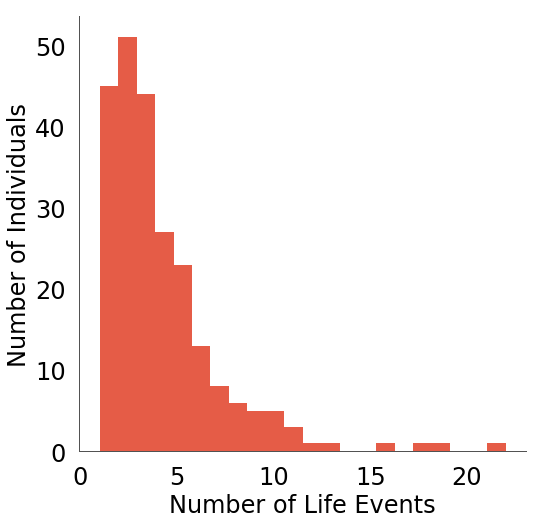

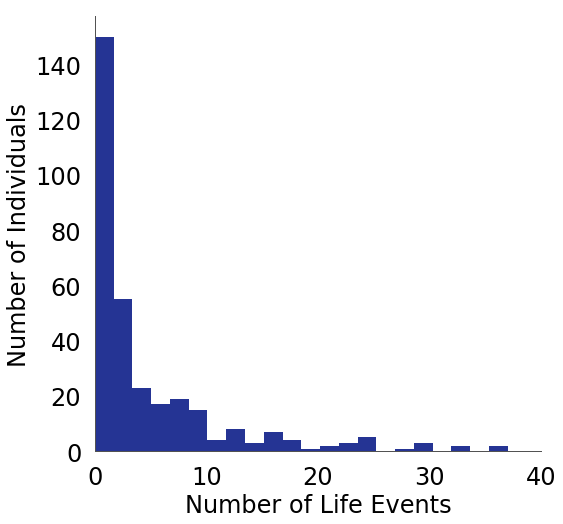

In [1703]:
def plotLifeEventsDist(vector, fileName, srsm):

    frequencyPlot = fileName
    pp.figure(figsize=(8, 8))
    setupMPPTufte()
    neuColor = "#969696"
    lrColor, nlrColor = "#49006a", "#e66101"
    csCol, ctCol, neitherCol = "#2c7bb6", "#d7191c", "#636363"
    srCol, smCol = "#e34a33", "#253494"
    mtchCol, unmtchCol = "#dd1c77", "#31a354"
    greyCol = "#636363"

    if(srsm==1):
        color = srCol
        alphaVal = 0.9
    else:
        color = smCol
        alphaVal = 1
    ax = sns.distplot(vector, kde = False, norm_hist = False, hist_kws = {"edgecolor": "none", "alpha": alphaVal, "cumulative": False, "color" : color})

    # pp.legend(loc='upper right')
    if srsm==0:
        pp.gca().set_xlim(0, 40)
    pp.gca().set_xlabel('Number of Life Events')
    pp.gca().set_ylabel('Number of Individuals')
#     pp.savefig(frequencyPlot+".png", bbox_inches="tight", transparent = True)
    pp.savefig(frequencyPlot+".pdf", bbox_inches="tight", transparent = True)
    pp.show()

    
plotLifeEventsDist (finalSrAggUsrDF.sentiment.values, "output/plots/dist_sr_2", 1)
plotLifeEventsDist (smAggUsrDF[smAggUsrDF.final_life_event<40].final_life_event.values, "output/plots/dist_sm_2", 0)
    


In [1710]:
# finalSrAggFamilyDF = pd.DataFrame(igtbTotalDF[igtbTotalDF.sm_sr==0].groupby(["LifeEventFamily"])["snapshot_id"].count()).reset_index()
# finalSmAggFamilyDF = pd.DataFrame(igtbTotalDF[igtbTotalDF.sm_sr==1].groupby(["LifeEventFamily"])["snapshot_id"].count()).reset_index()

finalSrAggFamilyDF = pd.DataFrame(igtbTotalDF[igtbTotalDF.sm_sr==0].groupby(["LifeEventFamily"])["snapshot_id"].count()).reset_index()
finalSmAggFamilyDF = pd.DataFrame(igtbTotalDF[igtbTotalDF.sm_sr==1].groupby(["LifeEventFamily"])["snapshot_id"].count()).reset_index()

In [1711]:
# set(finalSmAggFamilyDF.LifeEventFamily.values), set(smDF2.LifeEventFamily.values)
set(finalSmAggFamilyDF.LifeEventFamily.values), set(smDF2.LifeEventFamily.values)


({'Financial', 'Health', 'Local', 'Personal', 'School', 'Work'},
 {'Financial', 'Health', 'Local', 'Personal', 'School', 'Work', nan})

In [1712]:
cats = ["School", "Health", "Financial", "Work", "Personal", "Local"]
# cats = ["School", "Health", "Financial", "Work", "CrimeAndLegal", "Family", "HavingChildren", "LoveAndMarriage", "Residence", "SocialActivities", "Local"]
offResults = [(finalSrAggFamilyDF[finalSrAggFamilyDF.LifeEventFamily==x].snapshot_id.values[0])/len(igtbTotalDF[igtbTotalDF.sm_sr==0])*100 for x in cats]
onResults = [(finalSmAggFamilyDF[finalSmAggFamilyDF.LifeEventFamily==x].snapshot_id.values[0])/len(igtbTotalDF[igtbTotalDF.sm_sr==1])*100 if x in finalSmAggFamilyDF.LifeEventFamily.values else 0 for x in cats]


In [1713]:
offResults, onResults

([1.3157894736842104,
  9.649122807017543,
  7.12719298245614,
  32.45614035087719,
  39.03508771929825,
  10.416666666666668],
 [4.8019207683073235,
  8.28331332533013,
  1.0204081632653061,
  5.702280912364946,
  70.40816326530613,
  9.78391356542617])

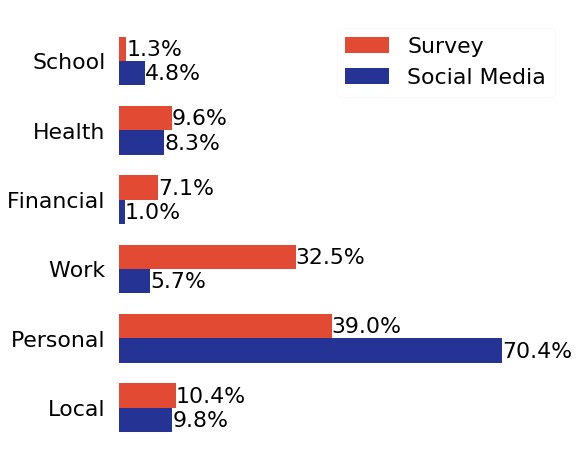

In [1714]:
frequencyPlot = "output/plots/eventsDistBarPlot2"
pp.figure(figsize=(8,8))
setupMPPTufte()
barWidth = 0.7 # the width of the bars 
ind = np.arange(len(cats))  # the x locations for the groups
srCol, smCol = "#e34a33", "#253494"


pp.barh(2 * ind, offResults, color=srCol, height=barWidth, label = "Survey")
pp.barh(2 * ind + barWidth, onResults, color=smCol, height=barWidth, label = "Social Media")



for i in range(len(cats)):
#     pp.text(-0.5, 2*i - 0*barWidth + barWidth, cats[i], color="black", fontsize = 24)
    plt.text(offResults[i], 2 * i +0.2,  str(round(offResults[i], 1))+"%", fontsize = 22)
    plt.text(onResults[i], 2 * i +0.2 +  barWidth, str(round(onResults[i], 1))+"%", fontsize = 22)


# text(0.5, 0.5, 'matplotlib', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

pp.yticks(2*ind+barWidth*0.5, cats, fontsize = 22)
pp.xlim([0, 82])
# plt.xlim((0, 20))

pp.gca().spines['left'].set_visible(False)
pp.gca().spines['bottom'].set_visible(False)
pp.gca().axes.get_xaxis().set_visible(False)
# plt.gca().axes.get_yaxis().set_visible(False)


# plt.ylim(-3, 4*len(results[0])-0.4)
pp.gca().set_xlabel('% Logged Events')    
pp.gca().invert_yaxis()

# plt.legend(bbox_to_anchor=(0, -0.08), loc=2, borderaxespad=0, ncol = 5, fontsize = 20, fancybox = True, framealpha = 0.1)
pp.legend(loc='upper right', fontsize = 22)
pp.savefig(frequencyPlot+".pdf", bbox_inches="tight", transparent = True)
pp.show()
# plt.savefig("plots/cluster3_vs_general.pdf", bbox_inches='tight', transparent = True)

In [1375]:
# frequencyPlot = "dist_sm_both"
# pp.figure(figsize=(10, 10))
# setupMPPTufte()
# neuColor = "#969696"
# lrColor, nlrColor = "#49006a", "#e66101"
# csCol, ctCol, neitherCol = "#2c7bb6", "#d7191c", "#636363"
# srCol, smCol = "#e34a33", "#253494"
# smCol2 = "#7fcdbb"
# mtchCol, unmtchCol = "#dd1c77", "#31a354"
# greyCol = "#636363"

# ax = sns.distplot(smAggUsrDF[smAggUsrDF.final_life_event<40].id.values, kde = False, norm_hist = False, hist_kws = {"edgecolor": "none", "alpha": 1, "cumulative": False, "color" : smCol}, label = "All")
# ax = sns.distplot(smAggUsrDF[smAggUsrDF.final_life_event<40].final_life_event.values, kde = False, norm_hist = False, hist_kws = {"edgecolor": "none", "alpha": 1, "cumulative": False, "color" : smCol2}, label = "Life Event")

# pp.gca().set_xlim(0, 300)
# pp.legend(loc='upper right')
# pp.gca().set_xlabel('Number of Posts')
# pp.gca().set_ylabel('Number of Individuals')
# #     pp.savefig(frequencyPlot+".png", bbox_inches="tight", transparent = True)
# # pp.savefig(frequencyPlot+".pdf", bbox_inches="tight", transparent = True)
# pp.show()

In [1376]:
finalSmDF.columns, srDF2.columns, smDF2.columns

(Index(['id', 'crawl_id', 'snapshot_id', 'date_enrolled', 'post_id',
        'created_time', 'Text', 'life_event_category_1', 'continuous_events_1',
        'Additional life event note_ 1', 'life_event_category_2',
        'continuous_events_2', 'Additional life event note_2',
        'life_event_category_3', 'final_life_event', 'sentiment',
        'SM_LifeEvent', 'LifeEventFamily', 'Anticipation', 'Intimacy', 'Scope',
        'Comments', 'sigScore', 'matchId', 'matchVal', 'sm_sr', 'date',
        'recency', 'LifeEventCat'],
       dtype='object'),
 Index(['EventID', 'snapshot_id', 'description', 'permanent_or_temporary',
        'ended_or_ongoing', 'end_date', 'date_confidence', 'significance',
        'valence', 'life_event_type', 'work_perf_impact', 'DupeStatus',
        'ExcludeCode', 'UpdatedBeginDate', 'UpdatedBeginDateCode',
        'UpdatedEndDate', 'UpdatedEndDateCode', 'alias', 'cohort', 'sentiment',
        'SR_LifeEvent', 'LifeEventFinal', 'LifeEventFamily', 'Anticipation'

In [1715]:
from collections import Counter
Counter(smDF2[smDF2.LifeEventFamily!=""].SM_LifeEvent.values).most_common()
# Counter(finalSmDF[finalSmDF.LifeEventFamily!=""].LifeEventCat.values).most_common()
# Counter(srDF2[srDF2.LifeEventFamily!=""].LifeEventFinal.values).most_common()
# Counter(igtbTotalDF[igtbTotalDF.matchVal==1].LifeEventCat.values).most_common()


[(nan, 12483),
 ('Vacation', 485),
 ('Trip', 227),
 ('Local', 164),
 ('IncreasedSocialActivity', 142),
 ('MoreLessFamilyMeetups', 106),
 ('PositiveRelationship', 85),
 ('HealthGain', 69),
 ('NewHobby', 67),
 ('Married', 53),
 ('Weather', 47),
 ('DeathInFamily', 45),
 ('BackToSchool', 42),
 ('GoodWorkLife', 34),
 ('Injury', 34),
 ('RemodeledHome', 34),
 ('HealthLoss', 33),
 ('FinishedSchool', 31),
 ('FriendDied', 26),
 ('WorkSuccess', 25),
 ('PositiveMove', 25),
 ('NewPet', 23),
 ('FirstChild', 23),
 ('NewProject', 14),
 ('PersonMovedOut', 12),
 ('NeutralMove', 12),
 ('PetDied', 12),
 ('ChangedSchool', 12),
 ('NegativeMove', 10),
 ('Pregnant', 10),
 ('BadWorkLife', 9),
 ('VacationPlanFail', 8),
 ('NewFriends', 8),
 ('FinancialLoss', 8),
 ('InstallmentPurchase', 6),
 ('DroppedHobby', 6),
 ('Expansion', 5),
 ('Robbed', 5),
 ('FamilyEvent', 5),
 ('BackToWork', 5),
 ('BreakFromWork', 4),
 ('ChildDied', 4),
 ('SportsEvent', 4),
 ('Engaged', 4),
 ('NonWorkFinancialGain', 4),
 ('NoInjuryAccide

In [1381]:
# overlappingDF = igtbTotalDF[igtbTotalDF.matchVal==1]
# overlappingDF = finalSrDF[finalSrDF.matchVal==1]
overlappingDF = pandas.merge(finalSmDF, finalSrDF, on = "matchId")
print(overlappingDF.shape)
overlappingDF.to_csv("output/overlappingTxtDF.txt", index = False, sep = "\t")
# overlappingDF.shape
# overlappingDF.head()
# overlappingDF.matchId.values

# finalSrDF.matchId.values, finalSmDF.matchId.values


(140, 61)


In [1382]:
print(len(igtbTotalDF[igtbTotalDF.sm_sr==1]), len(igtbTotalDF[igtbTotalDF.sm_sr==0]))

1669 912


In [1300]:
from sklearn.feature_extraction.text import CountVectorizer

def ngramCounts(textList):

    ngVectorizer = CountVectorizer(input='content',analyzer='word',lowercase = False, strip_accents='ascii',ngram_range=(1,3),max_features=50, stop_words="english")
    # workVectorizer.vocabulary_
    ngX = ngVectorizer.fit_transform(textList)
    vocab = ngVectorizer.vocabulary_
    vocabCount = dict(vocab)
    print(vocab)
    ngXDF = pandas.DataFrame(ngX.todense())
    # ngX

    for key, colNo in vocab.items():
        vocabCount[key] = np.sum(ngXDF[colNo].values)
    vocabCountDF = pandas.DataFrame.from_dict(vocabCount, orient = "index")
    vocabCountDF["word"] = vocabCountDF.index
    vocabCountDF[0] = standardizeVector(vocabCountDF[0].values)
    vocabCountDF[0] = [int(x*1000+1) for x in vocabCountDF[0].values]
    return vocabCountDF
    


# textList = [str(x) for x in smDF2[smDF2.LifeEventFamily=="Work"].Text.values]
textList = [str(x) for x in smDF2[smDF2.LifeEventFamily=="Work"].SM_LifeEvent.values]
vocabCountDF = ngramCounts(textList)    
vocabCountDF.to_csv("output/SM_WorkWords.csv", index = False)
textList = [str(x) for x in srDF2[srDF2.LifeEventFamily=="Work"].LifeEventFinal.values]
vocabCountDF = ngramCounts(textList)    
vocabCountDF.to_csv("output/SR_WorkWords.csv", index = False)


# vocabCountDF.to_csv("output/SM_WorkWords.txt", sep = " ")

textList = [str(x) for x in smDF2[smDF2.LifeEventFamily=="Financial"].Text.values]
vocabCountDF = ngramCounts(textList)    
vocabCountDF.to_csv("output/SM_FinancialWords.csv")


textList = [str(x) for x in smDF2[smDF2.LifeEventFamily=="Personal"].Text.values]
vocabCountDF = ngramCounts(textList)    
vocabCountDF.to_csv("output/SM_PersonalWords.csv")

textList = [str(x) for x in smDF2[smDF2.LifeEventFamily=="Local"].Text.values]
vocabCountDF = ngramCounts(textList)    
vocabCountDF.to_csv("output/SM_LocalWords.csv")

textList = [str(x) for x in smDF2[smDF2.LifeEventFamily=="School"].Text.values]
vocabCountDF = ngramCounts(textList)    
vocabCountDF.to_csv("output/SM_SchoolWords.csv")


# ngX.columns = 
# print(len(textList))
# text = " ".join(textList)
# print(text)

{'WorkLoss': 14, 'StartUp': 13, 'BadWorkLife': 1, 'PositiveJobSwitch': 11, 'FirstJob': 5, 'NeutralJobSwitch': 8, 'NoSalaryIncrement': 10, 'BackToWork': 0, 'Fired': 4, 'Expansion': 3, 'Promoted': 12, 'BreakFromWork': 2, 'NewProject': 9, 'GoodWorkLife': 6, 'HeavyWork': 7, 'WorkSuccess': 15}
{'WorkLoss': 21, 'StartUp': 20, 'PerformanceReview': 14, 'BadWorkLife': 1, 'PositiveJobSwitch': 15, 'QuarterEnd': 17, 'GotBonus': 7, 'NoPromotion': 12, 'NeutralJobSwitch': 10, 'MiscEvent': 9, 'BackToWork': 0, 'NoSalaryIncrement': 13, 'Expansion': 4, 'Fired': 5, 'SalaryCut': 18, 'Promoted': 16, 'BreakFromWork': 3, 'BossTrouble': 2, 'NewProject': 11, 'GoodWorkLife': 6, 'SalaryIncrement': 19, 'WorkSuccess': 22, 'HeavyWork': 8}
{'damage': 14, 'just': 25, 'paypal': 34, 'room': 37, 'dealership': 16, 'So': 3, 'didn': 17, 'let': 27, 'We bought': 8, 'saw': 39, 'They pay': 5, 'start': 40, 'We bought house': 9, 'years': 49, 'things': 42, 'car': 13, 'ended': 18, 'new': 32, 'Its': 1, 'wait': 44, 'way': 47, 'fix': 

In [1385]:
len(smDF2), len(smDF2[smDF2.LifeEventFamily.notnull()])

(14359, 2031)

In [1262]:
from wordcloud import WordCloud
frequencyPlot = "dist_sm_both"
pp.figure(figsize=(10, 10))
# setupMPPTufte()

# Read the whole text.
# textList = [str(x) for x in finalSmDF[finalSmDF.LifeEventFamily=="Personal"].Text.values]
# textList = [str(x) for x in finalSmDF[finalSmDF.LifeEventFamily=="Financial"].Text.values]
# textList = [str(x) for x in smDF2[smDF2.LifeEventFamily=="Financial"].Text.values]
textList = [str(x) for x in smDF2[smDF2.LifeEventFamily=="Work"].Text.values]
print(len(textList))
text = " ".join(textList)

# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(background_color="white",max_words=100,max_font_size=40, relative_scaling=.5).generate(text)
wordcloud.recolor(color_func = grey_color_func)

# pp.figure()
pp.imshow(wordcloud)
pp.axis("off")
pp.show()

119


NameError: name 'grey_color_func' is not defined

In [639]:
xCols = ['age', 'shipley.abs', 'neuroticism',
       'openness', 'extraversion', 'agreeableness', 'neg.affect', 'stai.trait',
       'conscientiousness', 'psqi', 'pos.affect',
       'shipley.vocab',"date", "sentiment", "sigScore", "sm_sr"]

In [640]:
X = igtbTotalDF[xCols].to_numpy()

In [244]:
X

array([[39.0, 15.0, 2.333333333, ..., 0, 0.004834031582339671, 1],
       [39.0, 15.0, 2.333333333, ..., 0, 0.04060586529165324, 1],
       [39.0, 15.0, 2.333333333, ..., 0, 0.053496616177892364, 1],
       ...,
       [35.0, 15.0, 3.3333333333333304, ..., -1, 1.0, 0],
       [35.0, 15.0, 3.3333333333333304, ..., 1, 2.0, 0],
       [35.0, 15.0, 3.3333333333333304, ..., 1, 2.0, 0]], dtype=object)

In [240]:
import statsmodels.api as sm

# spector_data = sm.datasets.spector.load(as_pandas=False)

# spector_data.exog = igtbTotalDF[xCols]

# Fit and summarize OLS model

mod = sm.OLS(igtbTotalDF.matchVal.values, X)

res = mod.fit()

print(res.summary())

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [186]:
finalSmDF.columns

Index(['id', 'crawl_id', 'snapshot_id', 'date_enrolled', 'post_id',
       'created_time', 'Text', 'life_event category', 'continuous_events',
       'Additional life event note', 'Unnamed: 10', 'LifeEventFamily',
       'sentiment', 'sigScore', 'concatLE', 'matchVal'],
      dtype='object')

In [12]:
# srDF.columns

# allDF = srDF.copy()
# allDF = allDF[["snapshot_id", "description", "significance", "valence", "life_event_type"]]

1547 423
236


In [26]:
df_annotated["created_date"] = pd.to_datetime(df_annotated.created_time,format='%Y-%m-%d',errors='coerce').dt.date

In [27]:
df_selfreport

,EventID,snapshot_id,description,permanent_or_temporary,ended_or_ongoing,end_date,date_confidence,significance,valence,life_event_type,work_perf_impact,DupeStatus,ExcludeCode,UpdatedBeginDate,UpdatedBeginDateCode,UpdatedEndDate,UpdatedEndDateCode,alias,cohort
0,1,12516215411311181588,Took a vacation,Temporary,Ended,07/07/2018,Highest confidence,Moderate significance,Very Positive,personal,Small positive effect,0.0,0,2018-07-07,2,2018-07-28,2,198893166f8ce36e20d8796fb6a61cd4,D
1,3,12131199544704830706,Vacation,Temporary,Ended,05/28/2018,Highest confidence,Moderate significance,Extremely Positive,personal,Small positive effect,0.0,0,2018-05-12,0,2018-05-28,0,fa3f9bc3a8a9957e815a22c62eda1aeb,D
2,4,10218374518126117174,car crash,Temporary,Ended,12/15/2018,High confidence,Moderately low significance,Somewhat Negative,personal,No effect,0.0,0,2018-11-15,0,2018-12-15,0,b5ca1b466bcfb6af09e37cecc301cab5,D
3,5,12680617526080257161,I moved to tampa florida in APril 2019,Temporary,Ended,10/18/2018,Highest confidence,High significance,Extremely Positive,personal,Large positive effect,0.0,0,2018-10-18,2,2019-04-10,7,3a78f1e66fd3104c89b3f56b089b4b1b,D
4,6,13467047711801587306,Vacation,Temporary,Ended,12/01/2018,Highest confidence,Moderately low significance,Somewhat Positive,personal,Medium positive effect,0.0,0,2018-11-01,0,2018-12-01,0,0c106a1bfc1318bf2b9dc58752d95170,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,1960,12718614204893805965,bitter cold - pipes in house froze,Temporary,Ended,03/15/2019,Moderate confidence,Very Negative,Moderately high significance,weather,NaN,NaN,0,2019-02-01,0,2019-03-15,0,71129c83a31d21b4b0ec4e19429f2af4,KLA
1191,1961,9883624450358368517,Below 0 temps-polar vortex,Temporary,Ended,02/03/2019,Moderately low confidence,Very Negative,Moderately high significance,weather,NaN,NaN,0,2019-01-29,0,2019-02-03,0,0eb4d5dc02df5bc17459e8e9a7933c11,KLA
1192,1962,12994028865111584912,Cold weather,Temporary,Ended,01/05/2019,Moderate confidence,Somewhat Positive,High significance,weather,NaN,NaN,0,2019-01-05,0,2019-01-05,0,943eea018230c4e3f77b52c42c28ee64,KLA
1193,1963,13146988918954476898,Blizzard,Temporary,Ended,01/29/2019,High confidence,Somewhat Negative,Moderate significance,weather,NaN,NaN,0,2019-01-27,0,2019-01-29,0,9f4609c6cbede9c31b37077a43aa73de,KLA


In [28]:
df_annotated
df_annotated['life_event category'].unique()

array(['RemodeledHome', 'PositiveRelationship', nan, 'Married', 'Trip',
       'Vacation', 'NewHobby', 'FinishedSchool',
       'IncreasedSocialActivity', 'WorkSuccess', 'YoungerChildBirth',
       'StartUp', 'VacationPlanFail', 'LostHomeInDisaster',
       'DeathInFamily', 'ChangedSchool', 'Robbed', 'BackToSchool',
       'MoreLessFamilyMeetups', 'AdoptedChild', 'PetDied', 'HealthGain',
       'HealthLoss', 'InstallmentPurchase', 'WorkLoss',
       'NoSalaryIncrement', 'FinancialLoss', 'FriendDied', 'Injury',
       'NewPet', 'PostiveMove', 'PersonMoveIn', 'NonWorkFinancialGain',
       'Expansion', 'Pregnant', 'BadWorkLife', 'GoodWorkLife',
       'NewFriends', 'FirstChild', 'PersonMovedOut', 'DroppedHobby',
       'CourtCase', 'NeutralMove', 'NoInjuryAccident', 'BackToWork',
       'HeavyWork', 'Assaulted', 'BreakFromWork', 'PositiveJobSwitch',
       'Mortgage', 'ChildDied', 'Engaged', 'NegativeMove', 'Menopause',
       'MiscarriageStillbirth', 'IssueAtSchool', ' ', 'BuildHome',
 

In [29]:
def map_self_reported_categories_to_annotated_categories(filename):
    file = pd.read_csv(filename)
    self_reported = file['Categories from Survey']
    mapped_category = file['Final Category']
    mapped_dict = {self:mapped for (self, mapped) in zip(self_reported, mapped_category)}
    return mapped_dict    

In [30]:
mapped_dict = map_self_reported_categories_to_annotated_categories('data/self_reported_categories.csv')
mapped_dict

{'2019 Polar Vortex': 'BadWeather',
 '40 mile bike ride': 'SportsEvent',
 'AC broke - excessive heat': 'BadWeather',
 'Accepted to Business School': 'BackToSchool',
 'Acquired a pet': 'NewPet',
 'Acting showcase': 'WorkSuccess',
 'adopted a cat': 'NewPet',
 'Adopted two kittens': 'NewPet',
 'Adoption Loan (Mortgage)': 'InstallmentPurchase',
 'Annual evaluation': 'PerformanceReview',
 'Annual exam': 'PerformanceReview',
 'Annual performance review': 'PerformanceReview',
 'Annual Review': 'PerformanceReview',
 'annual review': 'PerformanceReview',
 'Anxiety': 'HealthLoss',
 'Assaulted': 'Assaulted',
 'assaulted': 'Assaulted',
 "Attended a friend's wedding": 'Trip',
 'Attended car race at Watkins Glen': 'SportsEvent',
 'Attended car race in Atlanta': 'SportsEvent',
 'Attended car race in Dayton Floriday': 'SportsEvent',
 'Attended car race in Sebring Florida': 'SportsEvent',
 'Attended car race in Virginia': 'SportsEvent',
 "Attended my roommate's wedding": 'Trip',
 'attended Purdue baske

In [31]:
def change_self_reported_categories_in_file(filename, map_dict):
    file = pd.read_csv(filename)
#     print(file)
    category = file['description']
    file = file.replace(map_dict)
    return file

In [32]:
df_selfreport_mapped = change_self_reported_categories_in_file('data/LifeEvents_Curated_non_blinded.csv', mapped_dict)
df_selfreport_mapped.head()
# print(type(df_selfreport_mapped['UpdatedBeginDate'].iloc[0]))

,EventID,snapshot_id,description,permanent_or_temporary,ended_or_ongoing,end_date,date_confidence,significance,valence,life_event_type,work_perf_impact,DupeStatus,ExcludeCode,UpdatedBeginDate,UpdatedBeginDateCode,UpdatedEndDate,UpdatedEndDateCode,alias,cohort
0,1,12516215411311181588,Vacation,Temporary,Ended,07/07/2018,Highest confidence,Moderate significance,Very Positive,personal,Small positive effect,0,0,2018-07-07,2,2018-07-28,2,198893166f8ce36e20d8796fb6a61cd4,D
1,3,12131199544704830706,Vacation,Temporary,Ended,05/28/2018,Highest confidence,Moderate significance,Extremely Positive,personal,Small positive effect,0,0,2018-05-12,0,2018-05-28,0,fa3f9bc3a8a9957e815a22c62eda1aeb,D
2,4,10218374518126117174,NonMedicalIssueAccident,Temporary,Ended,12/15/2018,High confidence,Moderately low significance,Somewhat Negative,personal,No effect,0,0,2018-11-15,0,2018-12-15,0,b5ca1b466bcfb6af09e37cecc301cab5,D
3,5,12680617526080257161,PositiveMove,Temporary,Ended,10/18/2018,Highest confidence,High significance,Extremely Positive,personal,Large positive effect,0,0,2018-10-18,2,2019-04-10,7,3a78f1e66fd3104c89b3f56b089b4b1b,D
4,6,13467047711801587306,Vacation,Temporary,Ended,12/01/2018,Highest confidence,Moderately low significance,Somewhat Positive,personal,Medium positive effect,0,0,2018-11-01,0,2018-12-01,0,0c106a1bfc1318bf2b9dc58752d95170,D


In [33]:
def map_social_media_categories_to_annotated_categories(filename):
    file = pd.read_csv(filename)
    self_reported = file['Final Category']
    mapped_category = file['Mapped Category']
    mapped_dict = {self:mapped for (self, mapped) in zip(self_reported, mapped_category)}
    return mapped_dict    

In [34]:
social_media_categories = map_social_media_categories_to_annotated_categories('data/social-media-categories.csv')
social_media_categories

{'Mortgage': 'Mortgage',
 'InstallmentPurchase': 'InstallmentPurchase',
 'SoldHouse': 'SoldHouse',
 'MortgageClosed': 'MortgageClosed',
 'ReboughtOnInstallment': 'ReboughtOnInstallment',
 'SalaryCut': 'SalaryCut',
 'FinancialLoss': 'FinancialLoss',
 'OnWelfare': 'OnWelfare',
 'OffWelfare': 'OffWelfare',
 'SalaryIncrement': 'SalaryIncrement',
 'NoSalaryIncrement': 'NoAddedIncome',
 'NonWorkFinancialGain': 'NonWorkFinancialGain',
 'MiscFinancialChange': 'MiscFinancialChange',
 'Abortion': 'Abortion',
 'MiscarriageStillbirth': 'MiscarriageStillbirth',
 'Menopause': 'Menopause',
 'HealthGain': 'HealthGain',
 'HealthLoss': 'MedicalIssue',
 'Injury': 'MedicalIssue',
 'NoTreatment': 'NoTreatment',
 'Surgery': 'Surgery',
 'HealthGainFriendRelative': 'HealthGainFriendRelative',
 'HealthLossFriendRelative': 'HealthLossFriendRelative',
 'Hospitalization': 'Hospitalization',
 'HealthTreatment': 'HealthTreatment',
 'Engaged': 'Engaged',
 'BrokenEngagement': 'BrokenEngagement',
 'Married': 'Married'

In [35]:
def change_social_media_categories_in_file(filename, map_dict):
    file = pd.read_csv(filename)
#     print(file)
    category = file['life_event category']
    file = file.replace(map_dict)
    return file

In [36]:
df_social_mapped = change_social_media_categories_in_file('data/LifeEvents.csv', social_media_categories)
df_social_mapped.head()

,id,crawl_id,snapshot_id,date_enrolled,post_id,created_time,Text,life_event category,continuous_events,Additional life event note,Unnamed: 10,LifeEventFamily
0,58475.0,732,12502660685247488411,2018-01-24 0:00:00,10101243627963478_10101248581117318,2018-01-29 12:19:50,I have been working on projects in my garage t...,RemodeledHome,NaN,"""CompleteGoal"" - could be a new category for f...",NaN,Personal
1,63865.0,776,13146988918954476898,2018-01-24 0:00:00,10160028023085445_10160030616440445,2018-02-08 13:43:15,"Another year, another birthday with this speci...",PositiveRelationship,NaN,NaN,NaN,Personal
2,63863.0,776,13146988918954476898,2018-01-24 0:00:00,10160028023085445_10160044937885445,2018-02-11 19:29:08,#truemu,NaN,NaN,NaN,NaN,NaN
3,63864.0,776,13146988918954476898,2018-01-24 0:00:00,10160028023085445_10160041549375445,2018-02-10 23:24:48,Cab & Coffee. #weddingdrinks 🍷☕️,Married,NaN,NaN,NaN,Personal
4,147923.0,1314,13532032371364844572,2018-03-15 0:00:00,10155476277337725_10155509916507725,2018-03-15 0:15:15,"Your pictures are on this post, so wanted to s...",NaN,NaN,NaN,NaN,NaN


In [37]:
def check_if_reported_in_social_media(event, date, timeframe, df, idnum):
    end_date = datetime.strptime(date.replace('-', '/'), '%Y/%m/%d') + timedelta(days = timeframe)
    end_date = end_date.strftime('%Y/%m/%d').replace('/', '-')
    start_date = datetime.strptime(date.replace('-', '/'), '%Y/%m/%d') - timedelta(days = timeframe)
    start_date = start_date.strftime('%Y/%m/%d').replace('/', '-')
#     df = pd.read_csv(file)
    
    df['created_time"'] = pd.to_datetime(df.created_time,format='%Y-%m-%d',errors='coerce').dt.date
#     df['created_time'] = df['created_time'].apply(lambda x: x.strftime('%Y-%m-%d'))
#     print(df.head())
    df = df[df['created_time'] > start_date]
    df = df[df['created_time'] < end_date]
    df = df[df['snapshot_id'] == idnum]
    df = df[df['life_event category'] == event]
#     print(len(df))
    return len(df)

In [38]:
num_events = check_if_reported_in_social_media('PositiveRelationship', '2018-01-20', 30, df_social_mapped, 13146988918954476898)
print(num_events)

1


In [39]:
def get_all_reported_events_within_timeframe(df_self, df_annotated, df_social, timeframe):
    
    events_dict = {val: 0 for val in df_social['life_event category'].unique()}
    
    for count, info in enumerate(zip(df_self['snapshot_id'], df_self['description'], 
                                     df_self['UpdatedBeginDate'], df_self['EventID'])):
        if (type(info[2]) == str):
            try:
                if (check_if_reported_in_social_media(info[1], info[2], timeframe, df_social, info[0]) > 0):
                    events_dict[info[1]] += 1
            except:
                print('error')
                continue
    events_dict = {key: value for (key, value) in events_dict.items() if value != 0}
    return events_dict
            

In [ ]:
get_all_reported_events_within_timeframe(df_selfreport_mapped, df_annotated, df_social_mapped, 3)

error


In [ ]:
get_all_reported_events_within_timeframe(df_selfreport_mapped, df_annotated, df_social_mapped, 7)

In [ ]:
get_all_reported_events_within_timeframe(df_selfreport_mapped, df_annotated, df_social_mapped, 21)

In [ ]:
get_all_reported_events_within_timeframe(df_selfreport_mapped, df_annotated, df_social_mapped, 60)

In [ ]:
def get_all_unreported_events_within_timeframe(df_self, df_annotated, df_social, timeframe):
    
    events_dict = {val: 0 for val in df_self['description'].unique()}
    
    for count, info in enumerate(zip(df_self['snapshot_id'], df_self['description'], 
                                     df_self['UpdatedBeginDate'], df_self['EventID'])):
        if (type(info[2]) == str):
            try:
#                 print('here')
                if (check_if_reported_in_social_media(info[1], info[2], timeframe, df_social, info[0]) == 0):
#                     print(info[1])
                    events_dict[info[1]] += 1
            except:
                print('error')
                continue
    events_dict = {key: value for (key, value) in events_dict.items() if value != 0}
    return events_dict
            

In [ ]:
get_all_unreported_events_within_timeframe(df_selfreport_mapped, df_annotated, df_social_mapped, 3)

In [ ]:
get_all_unreported_events_within_timeframe(df_selfreport_mapped, df_annotated, df_social_mapped, 7)

In [ ]:
get_all_unreported_events_within_timeframe(df_selfreport_mapped, df_annotated, df_social_mapped, 21)

In [ ]:
get_all_unreported_events_within_timeframe(df_selfreport_mapped, df_annotated, df_social_mapped, 60)